Dataset used: UJIIndoorLoc https://archive.ics.uci.edu/ml/datasets/ujiindoorloc

Indoor Positioning Systems aims to detect the position of user or device by using Access Points’ signal also called “Wi-Fi fingerprint”. Each WiFi fingerprint can be characterized by the detected Wireless Access Points (WAPs) and the corresponding Received Signal Strength Intensity (RSSI). Then the coordinates (latitude, longitude, building number & floor) and Building ID are provided as the attributes to be predicted.

The UJIIndoorLoc database covers three buildings of Universitat Jaume I with 4 or more floors and almost 110.000m2. It can be used for classification, e.g. actual building and floor identification, or regression, e.g. actual longitude and latitude estimation. The database consists of 19937 training/reference records (trainingData.csv file) and 1111 validation/test records (validationData.csv file). 

This notebook focuses on setup of "position esitmation algorithm" illustrated in diagram below, by performing classification tasks. Two seperate deep learning models were setup to identify position of Wi-Fi user/device in terms of:

1.   building ID
2.   floor level



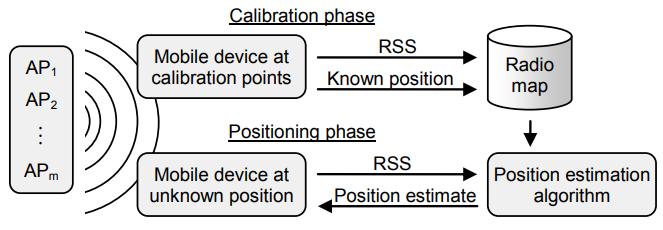

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import datetime
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from timeit import default_timer as timer

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import scale, StandardScaler

In [ ]:
# cwd = os.getcwd()
# for dirname, _, filenames in os.walk('/content/drive/MyDrive/Indoor Localization'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

path_train = '/content/drive/MyDrive/Indoor Localization/TrainingData.csv'
path_validation = '/content/drive/MyDrive/Indoor Localization/ValidationData.csv'

###----------------------------------------------------------------------------------------------###
# Building ID prediction
###----------------------------------------------------------------------------------------------###

## Data preperation

In [4]:
train_df = pd.read_csv(path_train)
train_df.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,WAP013,WAP014,WAP015,WAP016,WAP017,WAP018,WAP019,WAP020,WAP021,WAP022,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP037,WAP038,WAP039,WAP040,...,WAP490,WAP491,WAP492,WAP493,WAP494,WAP495,WAP496,WAP497,WAP498,WAP499,WAP500,WAP501,WAP502,WAP503,WAP504,WAP505,WAP506,WAP507,WAP508,WAP509,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-92,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [5]:
# feature data prepration
feature_scaler = StandardScaler()
train_AP_features = feature_scaler.fit_transform(np.asarray(train_df.iloc[:,:520]).astype(float)) 

In [6]:
# Label data preperation - Building ID 
building_ids_str = train_df["BUILDINGID"].map(str) #convert building ids to strings
train_labels = np.asarray(building_ids_str)

#convert labels to categorical variables
dummy_labels = pd.get_dummies(train_labels)
train_labels = np.asarray(dummy_labels) #labels is an array of shape 19937 x 3. (there are 3 types of labels for building ID)

print(train_labels.shape)
train_labels[:5]

(19937, 3)


array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]], dtype=uint8)

In [7]:
#generate len(train_AP_features) of floats in between 0 and 1
train_val_split = np.random.rand(len(train_AP_features))
#convert train_val_split to an array of booleans: if elem < 0.9 = true, else: false
train_val_split = train_val_split < 0.9 #should contain ~90% percent true

In [8]:
# observe feature data
train_AP_features

array([[0.03006045, 0.0308837 , 0.        , ..., 0.03323095, 0.01226739,
        0.        ],
       [0.03006045, 0.0308837 , 0.        , ..., 0.03323095, 0.01226739,
        0.        ],
       [0.03006045, 0.0308837 , 0.        , ..., 0.03323095, 0.01226739,
        0.        ],
       ...,
       [0.03006045, 0.0308837 , 0.        , ..., 0.03323095, 0.01226739,
        0.        ],
       [0.03006045, 0.0308837 , 0.        , ..., 0.03323095, 0.01226739,
        0.        ],
       [0.03006045, 0.0308837 , 0.        , ..., 0.03323095, 0.01226739,
        0.        ]])

### Training and validation dataset preperation for model training

In [9]:
train_X = train_AP_features[train_val_split]
train_y = train_labels[train_val_split]
val_X = train_AP_features[~train_val_split]
val_y = train_labels[~train_val_split]

In [10]:
train_y.shape, val_y.shape

((17930, 3), (2007, 3))

In [11]:
# prepare test dataset
test_df = pd.read_csv(path_validation,header = 0)
test_AP_features = feature_scaler.transform(np.asarray(test_df.iloc[:,0:520]).astype(float))

test_labels = np.asarray(test_df["BUILDINGID"].map(str) )
test_labels = np.asarray(pd.get_dummies(test_labels))

In [12]:
test_AP_features.shape, test_labels.shape

((1111, 520), (1111, 3))

## Modelling & Model Training - Building ID prediction

In [13]:
epochs = 20
batch_size = 32
input_size = 520
num_classes = train_y.shape[1]
nums_hidden_nodes = [512] 
# nums_hidden_nodes = [128, 256, 512]
dropout_rates = [0.5] # for test
dropout_rate2 = 0.5
# dropout_rates = [0.0, 0.2, 0.5]
losses = np.zeros((len(nums_hidden_nodes), len(dropout_rates)))
accuracies = np.zeros_like(losses)

In [14]:
def classifier(num_hidden_nodes, dropout_rate):

  input = Input(shape=(input_size,), name='Input')
  x = Dense( num_hidden_nodes, activation='relu' )(input)
  x = Dropout(dropout_rate)(x)
  # x = Dense( 256, activation='relu' )(x)
  # x = Dropout(dropout_rate2)(x)
  x = Dense( 128, activation='relu' )(x)
  x = Dropout(dropout_rate2)(x)
  x = Dense( 64, activation='relu' )(x)
  x = Dropout(dropout_rate2)(x)
  x = Dense( 32, activation='relu' )(x)
  x = Dropout(dropout_rate2)(x)
  output = Dense( num_classes, activation='softmax' )(x)

  model = Model(input, output)
  print(model.summary())

  model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

  return model

In [15]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Indoor Localization/models/class_best_weights.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
# early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=5,verbose=0,mode='auto')   # not in use, as accuracy over test data is poorer after stopping 'too early'

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 520)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               266752    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0     

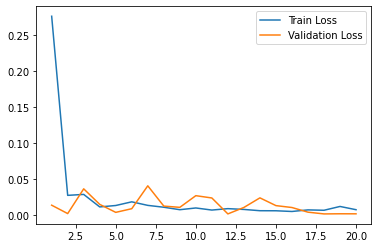

Model trained with nh=512 & dr=0.50 in 8.262445e+01 s.

35/35 [==============================] - 0s 3ms/step - loss: 0.7012 - accuracy: 0.9766


In [16]:
classifiers_list = []

for nh in range(len(nums_hidden_nodes)):
    for dr in range(len(dropout_rates)):
        c = classifier(nums_hidden_nodes[nh], dropout_rates[dr])

        startTime = timer()
        result = c.fit(train_X, train_y, 
                        validation_data=(val_X, val_y), 
                        batch_size=batch_size, 
                        epochs=epochs,
                        callbacks=[checkpoint])
        elapsedTime = timer() - startTime

        training_runs_num = len(result.history['val_loss'])
        x_vals = range(1, training_runs_num+1)
        plt.plot(x_vals, result.history['loss'], label = 'Train Loss')
        plt.plot(x_vals, result.history['val_loss'], label = 'Validation Loss')
        plt.legend()
        plt.show()

        print("Model trained with nh=%d & dr=%.2f in %e s.\n" % (nums_hidden_nodes[nh], dropout_rates[dr], elapsedTime))
        loss, acc = c.evaluate(test_AP_features, test_labels)
        losses[nh, dr] = loss
        accuracies[nh, dr] = acc

        classifiers_list.append(c)

## Model evaluation - Building ID prediction

In [17]:
print(len(classifiers_list))

predictions = classifiers_list[0].predict(test_AP_features) # there is only one classifier, hence use the first classifer in list
prediction_index = tf.math.argmax(predictions, axis=1)
test_labels_index = tf.math.argmax(test_labels, axis=1)
equality = tf.math.equal(prediction_index, test_labels_index)
accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))
accuracy

1


<tf.Tensor: shape=(), dtype=float32, numpy=0.97659767>

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix( test_labels_index,  prediction_index )
cm

array([[512,   1,  23],
       [  1, 305,   1],
       [  0,   0, 268]])

In [19]:
for c in range(num_classes):
    tp = cm[c,c]
    fp = sum(cm[:,c]) - cm[c,c]
    fn = sum(cm[c,:]) - cm[c,c]
    tn = sum(np.delete(sum(cm)-cm[c,:],c))

    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    specificity = tn/(tn+fp)
    f1_score = 2*((precision*recall)/(precision+recall))
    

    # print(f"for class {c}: acc {accuracy}, recall {recall},\
    #      precision {precision}, f1 {f1_score}")
    print("for class {}: recall {}, specificity {}\
          precision {}, f1 {}".format(c,round(recall,4), round(specificity,4), round(precision,4),round(f1_score,4)))

for class 0: recall 0.9552, specificity 0.9983          precision 0.9981, f1 0.9762
for class 1: recall 0.9935, specificity 0.9988          precision 0.9967, f1 0.9951
for class 2: recall 1.0, specificity 0.9715          precision 0.9178, f1 0.9571


###----------------------------------------------------------------------------------------------###
# Floor level prediction
###----------------------------------------------------------------------------------------------###

It is assumed that 'building ID' data is available as inference output from model trained above. This output is added as feature into below model for floor level prediction. 

My hypothesis that adding 'building ID' as a feature can help improve model inference accuracy.

## Data preperation

In [20]:
# feature data prepration
# Given i had a 97% classification accuracy for building ID in model earlier, i just included the building ID from original dataset
train_AP_strengths_bldg = train_df.drop(columns=["LONGITUDE", "LATITUDE", "FLOOR", "SPACEID", "RELATIVEPOSITION", "USERID", "PHONEID", "TIMESTAMP"])

feature_scaler2 = StandardScaler()
train_AP_features = feature_scaler2.fit_transform(np.asarray(train_AP_strengths_bldg).astype(float)) 

3    0.253198
1    0.250890
2    0.221498
0    0.219140
4    0.055274
Name: FLOOR, dtype: float64

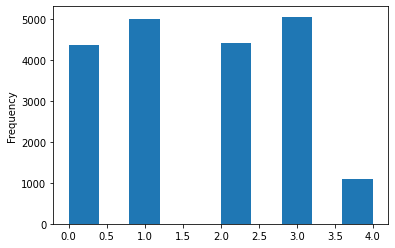

In [21]:
# Label data preperation - Floor level
building_floors_str = train_df["FLOOR"].map(str) #convert all the building floors to strings
train_labels = np.asarray(building_floors_str)

#convert labels to categorical variables
dummy_labels = pd.get_dummies(train_labels)
train_labels = np.asarray(dummy_labels) #labels is an array of shape 19937 x 5. (there are 13 types of labels)

# Observe training data distribution of labels
train_df["FLOOR"].plot.hist()
train_df["FLOOR"].value_counts(normalize=True)

In [22]:
train_labels[:5]

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0]], dtype=uint8)

In [23]:
#generate len(train_AP_features) of floats in between 0 and 1
train_val_split = np.random.rand(len(train_AP_features))
#convert train_val_split to an array of booleans: if elem < 0.9 = true, else: false
train_val_split = train_val_split < 0.9 #should contain ~90% percent true

### Training and validation dataset preperation for model training

In [24]:
train_X = train_AP_features[train_val_split]
train_y = train_labels[train_val_split]
val_X = train_AP_features[~train_val_split]
val_y = train_labels[~train_val_split]

In [25]:
train_X.shape, train_y.shape, val_y.shape

((17924, 521), (17924, 5), (2013, 5))

In [26]:
# prepare test dataset
test_df = pd.read_csv(path_validation,header = 0)
test_AP_strengths_bldg = test_df.drop(columns=["LONGITUDE", "LATITUDE", "FLOOR", "SPACEID", "RELATIVEPOSITION", "USERID", "PHONEID", "TIMESTAMP"])
test_AP_features = feature_scaler2.transform(np.asarray(test_AP_strengths_bldg.iloc[:,0:521]).astype(float))

test_labels = np.asarray(test_df["FLOOR"].map(str) )
test_labels = np.asarray(pd.get_dummies(test_labels))

In [27]:
# Observe test data distribution of labels
test_df["FLOOR"].value_counts(normalize=True)

1    0.415842
2    0.275428
3    0.154815
0    0.118812
4    0.035104
Name: FLOOR, dtype: float64

In [28]:
test_AP_features.shape, test_labels.shape

((1111, 521), (1111, 5))

## Modelling & Model Training - Floor level prediction

In [29]:
epochs = 20
batch_size = 32
input_size = 521      # note include building ID feature
num_classes = train_y.shape[1]
nums_hidden_nodes = [1204] 
# nums_hidden_nodes = [128, 256, 512]
dropout_rates = [0.5] # for test
dropout_rate2 = 0.5
# dropout_rates = [0.0, 0.2, 0.5]
losses = np.zeros((len(nums_hidden_nodes), len(dropout_rates)))
accuracies = np.zeros_like(losses)

In [30]:
def classifier(num_hidden_nodes, dropout_rate):

  input = Input(shape=(input_size,), name='Input')
  x = Dense( num_hidden_nodes, activation='relu' )(input)
  x = Dropout(dropout_rate)(x)
  x = Dense( 256, activation='relu' )(x)
  x = Dropout(dropout_rate2)(x)
  # x = Dense( 128, activation='relu' )(x)
  # x = Dropout(dropout_rate2)(x)
  x = Dense( 64, activation='relu' )(x)
  x = Dropout(dropout_rate2)(x)
  x = Dense( 32, activation='relu' )(x)
  x = Dropout(dropout_rate2)(x)
  output = Dense( num_classes, activation='softmax' )(x)

  model = Model(input, output)
  print(model.summary())

  model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

  return model

In [31]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Indoor Localization/models/class_best_weights.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=5,verbose=0,mode='auto')   

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 521)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1204)              628488    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1204)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               308480    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0   

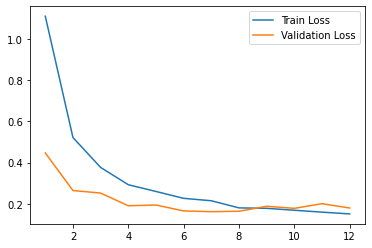

Model trained with nh=1204 & dr=0.50 in 8.688119e+01 s.

35/35 [==============================] - 0s 4ms/step - loss: 1.7249 - accuracy: 0.6823


In [32]:
classifiers_list = []

for nh in range(len(nums_hidden_nodes)):
    for dr in range(len(dropout_rates)):
        c = classifier(nums_hidden_nodes[nh], dropout_rates[dr])

        startTime = timer()
        result = c.fit(train_X, train_y, 
                        validation_data=(val_X, val_y), 
                        batch_size=batch_size, 
                        epochs=epochs,
                        callbacks=[checkpoint, early_stopping])
        elapsedTime = timer() - startTime

        training_runs_num = len(result.history['val_loss'])
        x_vals = range(1, training_runs_num+1)
        plt.plot(x_vals, result.history['loss'], label = 'Train Loss')
        plt.plot(x_vals, result.history['val_loss'], label = 'Validation Loss')
        plt.legend()
        plt.show()

        print("Model trained with nh=%d & dr=%.2f in %e s.\n" % (nums_hidden_nodes[nh], dropout_rates[dr], elapsedTime))
        loss, acc = c.evaluate(test_AP_features, test_labels)
        losses[nh, dr] = loss
        accuracies[nh, dr] = acc

        classifiers_list.append(c)

## Model evaluation - Building ID prediction

In [33]:
print(len(classifiers_list))

predictions = classifiers_list[0].predict(test_AP_features)     # there is only one classifier, hence use the first classifer in list
prediction_index = tf.math.argmax(predictions, axis=1)
test_labels_index = tf.math.argmax(test_labels, axis=1)
equality = tf.math.equal(prediction_index, test_labels_index)
accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))
accuracy

1


<tf.Tensor: shape=(), dtype=float32, numpy=0.6822682>

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix( test_labels_index,  prediction_index )
cm

array([[ 64,  61,   7,   0,   0],
       [ 12, 396,  52,   2,   0],
       [  0,  80, 194,  32,   0],
       [  0,  20,  63,  89,   0],
       [  0,  10,   6,   8,  15]])

In [35]:
for c in range(num_classes):
    tp = cm[c,c]
    fp = sum(cm[:,c]) - cm[c,c]
    fn = sum(cm[c,:]) - cm[c,c]
    tn = sum(np.delete(sum(cm)-cm[c,:],c))

    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    specificity = tn/(tn+fp)
    f1_score = 2*((precision*recall)/(precision+recall))
    

    # print(f"for class {c}: acc {accuracy}, recall {recall},\
    #      precision {precision}, f1 {f1_score}")
    print("for class {}: recall {}, specificity {}\
          precision {}, f1 {}".format(c,round(recall,4), round(specificity,4), round(precision,4),round(f1_score,4)))

for class 0: recall 0.4848, specificity 0.9877          precision 0.8421, f1 0.6154
for class 1: recall 0.8571, specificity 0.7365          precision 0.6984, f1 0.7697
for class 2: recall 0.634, specificity 0.841          precision 0.6025, f1 0.6178
for class 3: recall 0.5174, specificity 0.9553          precision 0.6794, f1 0.5875
for class 4: recall 0.3846, specificity 1.0          precision 1.0, f1 0.5556
